## MY CNN model

Test CNN model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BATCH_SIZE = 10
# IMG_SIZE = (500,500)
# IMG_W = 500
# IMG_H = 500
IMG_SIZE = (300,300)
IMG_W = 300
IMG_H = 300
# IMG_SIZE = (200,200)
# IMG_W = 200
# IMG_H = 200

In [4]:
train_dataset = image_dataset_from_directory("../../data_single/data_single_conv_split/train/",
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 569 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory("../../data_single/data_single_conv_split/val/",
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE)

Found 100 files belonging to 2 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['par1', 'wt']

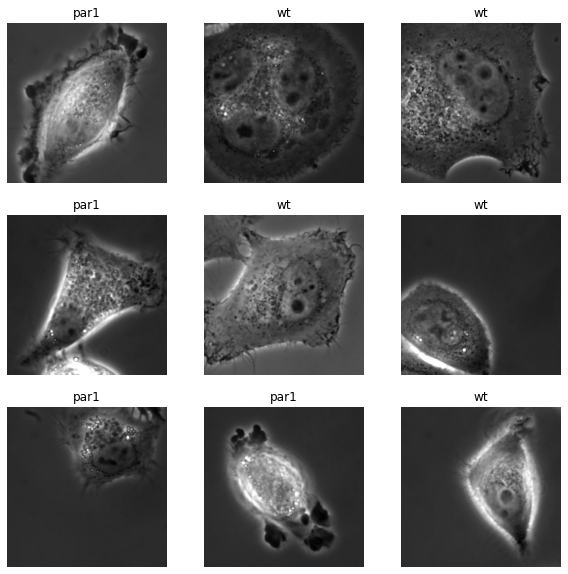

In [7]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [9]:
print("Number of validation batches : %d" %tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches : %d" %tf.data.experimental.cardinality(test_dataset))

Number of validation batches : 8
Number of test batches : 2


In [10]:
AUTOTUNE =tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

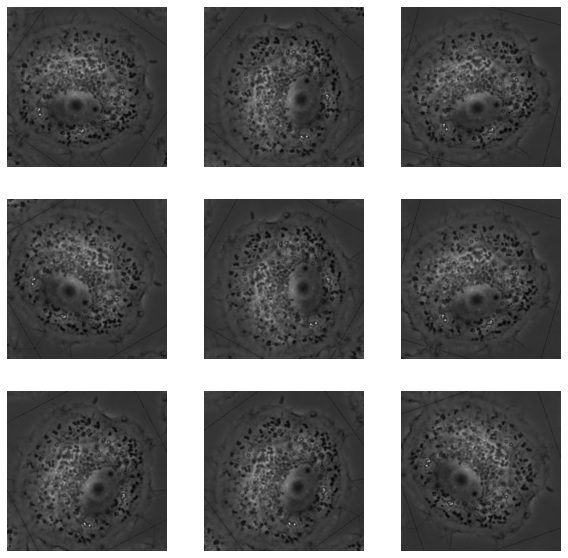

In [12]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [16]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

In [41]:
#### initially by me 
#### (500x500, dr=0.2, 20 epochs, val_accuracy: 0.4125)
#### (300x300, dr=0.2, es7 epochs, val_accuracy: 0.5750)
# def my_model(input_shape, drop_rate):
#     model = Sequential([
#         Conv2D(filters=32, input_shape=input_shape, kernel_size=(3,3), activation = 'relu'),
#         Dropout(drop_rate),
#         Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
#         Dropout(drop_rate),
#         Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
#         Dropout(drop_rate),
#         MaxPooling2D(pool_size=(4,4)),
#         BatchNormalization(),
#         Flatten(),
#         Dropout(drop_rate),
#         Dense(units=1024, activation='relu')
# #         Dense(units=1, activation='softmax')
#     ])
#     return model

def my_model(input_shape, drop_rate): # dr0.2/
    model = Sequential([
        Conv2D(filters=32, input_shape=input_shape, kernel_size=(3,3), activation = 'relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dropout(drop_rate),
        Dense(units=256, activation='relu'),
        Dropout(drop_rate),
        Dense(units=128, activation='softmax')
#         Dense(units=1, activation='softmax')
    ])
    return model

In [42]:
drop_rate = 0.4 #looks it works better than 0.5

model = my_model(first_image.shape, drop_rate)

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 156800)           

In [44]:
prediction_layer = tf.keras.layers.Dense(1, activation="relu")  
#default -linear, 0.5375
#softmax, 0.4000
#relu, 0.6250

In [45]:
inputs = tf.keras.Input(shape=(IMG_H, IMG_W, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = model(x)
outputs = prediction_layer(x)
cnn_model = tf.keras.Model(inputs, outputs)

In [46]:
base_lr = 0.0001
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr), 
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [47]:
cnn_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 128)               40267200  
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 40,267,329
Trainable params: 40,267,329
Non-trainable params: 0
_________________________________________________________________


In [48]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training ...")
    def on_train_end(self, logs=None):
        print("Finished training!")

early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

In [49]:
initial_epochs = 20
loss0, accuracy0 = cnn_model.evaluate(validation_dataset)

8/8 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.6250


In [50]:
print("initial loss : {:.2f}".format(loss0))
print("initial accuracy : {:.2f}".format(accuracy0))

initial loss : 0.69
initial accuracy : 0.62


In [51]:
# history = cnn_model.fit(train_dataset,
#                        epochs=initial_epochs,
#                        validation_data=validation_dataset,
#                        callbacks=[TrainingCallback(), early_stopping])
history = cnn_model.fit(train_dataset,
                       epochs=initial_epochs,
                       validation_data=validation_dataset,
                       callbacks=[TrainingCallback(), early_stopping])

Starting training ...
Epoch 1/20
57/57 [==============================] - 2s 33ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6931 - val_accuracy: 0.5875
Epoch 2/20
57/57 [==============================] - 2s 32ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6931 - val_accuracy: 0.5750
Epoch 3/20
57/57 [==============================] - 2s 33ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6931 - val_accuracy: 0.5750
Epoch 4/20
57/57 [==============================] - 2s 32ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6931 - val_accuracy: 0.5750
Epoch 5/20
57/57 [==============================] - 2s 32ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6931 - val_accuracy: 0.6375
Epoch 6/20
57/57 [==============================] - 2s 32ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6931 - val_accuracy: 0.6125
Epoch 7/20
57/57 [==============================] - 2s 33ms/step - loss: 0.6931 - accuracy: 0.5255 - val_loss: 0.6931 - val_accuracy

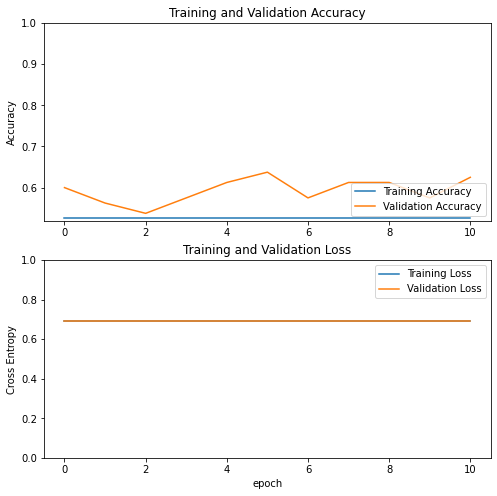

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [334]:
# import pickle
# with open("./cnn_model_test00",'wb') as file_pi:
#     pickle.dump(history_fine.history, file_pi)

In [335]:
# test_load = pickle.load(open("./cnn_model_test00",'rb'))
# test_load['loss']